# RNN Stock Price Forecasting

This notebook demonstrates a complete pipeline for one-step-ahead stock price prediction using recurrent neural networks built with TensorFlow/Keras.

**Pipeline overview**

1. Setup and imports  
2. Load and pre-processed the NYSE price dataset  
3. Prepare normalized rolling windows for training/validation/testing  
4. Train a stacked GRU model  
5. Evaluate predictions with plots and directional-accuracy metrics


Note:
* Dataset: Kaggle "New York Stock Exchange": #FALTA
* Solution adapted from: #FALTA
* The code assumes the CSV is extracted under `./prices-split-adjusted.csv/`.


# 1. Setup and Imports

Configure libraries, random seeds, and global settings used throughout the notebook.


In [34]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras import Sequential

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error


# Reproducibility
np.random.seed(42)
tf.random.set_seed(42)

VALID_SPLIT_PCT = 10
TEST_SPLIT_PCT = 10
FEATURES = ['open', 'high', 'low', 'close']  # Core price features

print(f"Working directory: {os.getcwd()}")

Working directory: c:\Users\asus\OneDrive - Universidade de Aveiro\Documents\GitHub\RNN_Practicise_exercises-solution


# 2. Load Data

* Loads a large dataset of stock prices.

* Displays basic info (rows, columns, tickers).

* Selects a specific company (EQIX).

* Extracts its relevant price data.

* Normalizes all numeric features between 0 and 1 for model readiness.

* Outputs a clean, ready-to-use DataFrame (stock_scaled) for analysis or training.

In [27]:
# Load the dataset

DATA_PATH = "prices-split-adjusted.csv"  # Path to your dataset file (CSV with stock data)
df = pd.read_csv(DATA_PATH)               # Read the CSV file into a pandas DataFrame

# Print basic dataset information
print(f"Rows: {len(df):,}")               # Show total number of rows (records)
print(f"Columns: {df.columns.tolist()}")  # Show list of column names

# ===============================================================
# Select one stock (EQUIX)

## Filter the DataFrame to keep only rows for the selected ticker,
## select only the desired features, sort by index (date order),
## and reset the index to start from 0.
stock = (
    df.loc[df.symbol == "EQIX", FEATURES]
      .sort_index()
      .reset_index(drop=True)
)

# ===============================================================
# Normalize the features

scaler = MinMaxScaler()  # Initialize a Min-Max Scaler (scales values to range [0, 1])

# Fit the scaler on the stock data and transform it to normalized values.
# Then, rebuild it into a pandas DataFrame with the same column names.
stock_scaled = pd.DataFrame(
    scaler.fit_transform(stock),
    columns=FEATURES
)


# ===============================================================
# Preview the result

stock_scaled.head()  # Display the first 5 rows of the normalized dataset



Rows: 851,264
Columns: ['date', 'symbol', 'open', 'close', 'low', 'high', 'volume']


,open,high,low,close
0,0.109250,0.110911,0.117440,0.122904
1,0.118896,0.110816,0.123361,0.119708
2,0.116886,0.113912,0.122855,0.122810
3,0.117828,0.113217,0.117852,0.115791
4,0.110130,0.103519,0.115509,0.114161


# 3. Prepare Data

Create normalized rolling windows to build supervised sequences and split them chronologically into training, validation, and test sets.


In [ ]:
def build_windows(values: np.ndarray, seq_len: int):
    """Create rolling windows of length `seq_len` from a [time, features] array."""
    windows = np.array([values[i:i + seq_len] for i in range(len(values) - seq_len)], dtype=np.float32)
    x = windows[:, :-1, :]
    y = windows[:, -1, :]
    return x, y


def split_data(x: np.ndarray, y: np.ndarray, valid_pct: int, test_pct: int):
    """Split the sequences chronologically into train/validation/test subsets."""
    total = x.shape[0]
    valid_len = int(round(valid_pct / 100 * total))
    test_len = int(round(test_pct / 100 * total))
    train_len = total - valid_len - test_len
    if train_len <= 0:
        raise ValueError("Split configuration leaves no data for training.")
    return (
        x[:train_len], y[:train_len],
        x[train_len:train_len + valid_len], y[train_len:train_len + valid_len],
        x[train_len + valid_len:], y[train_len + valid_len:]
    )


seq_len = 20

x_all, y_all = build_windows(stock_scaled.values, seq_len)
x_train, y_train, x_valid, y_valid, x_test, y_test = split_data(
    x_all, y_all, VALID_SPLIT_PCT, TEST_SPLIT_PCT
)

for name, array in {
    "x_train": x_train,
    "y_train": y_train,
    "x_valid": x_valid,
    "y_valid": y_valid,
    "x_test": x_test,
    "y_test": y_test,
}.items():
    print(f"{name}.shape = {array.shape}")


x_train.shape = (1394, 19, 4)
y_train.shape = (1394, 4)
x_valid.shape = (174, 19, 4)
y_valid.shape = (174, 4)
x_test.shape = (174, 19, 4)
y_test.shape = (174, 4)


### 3.1 Show dataset

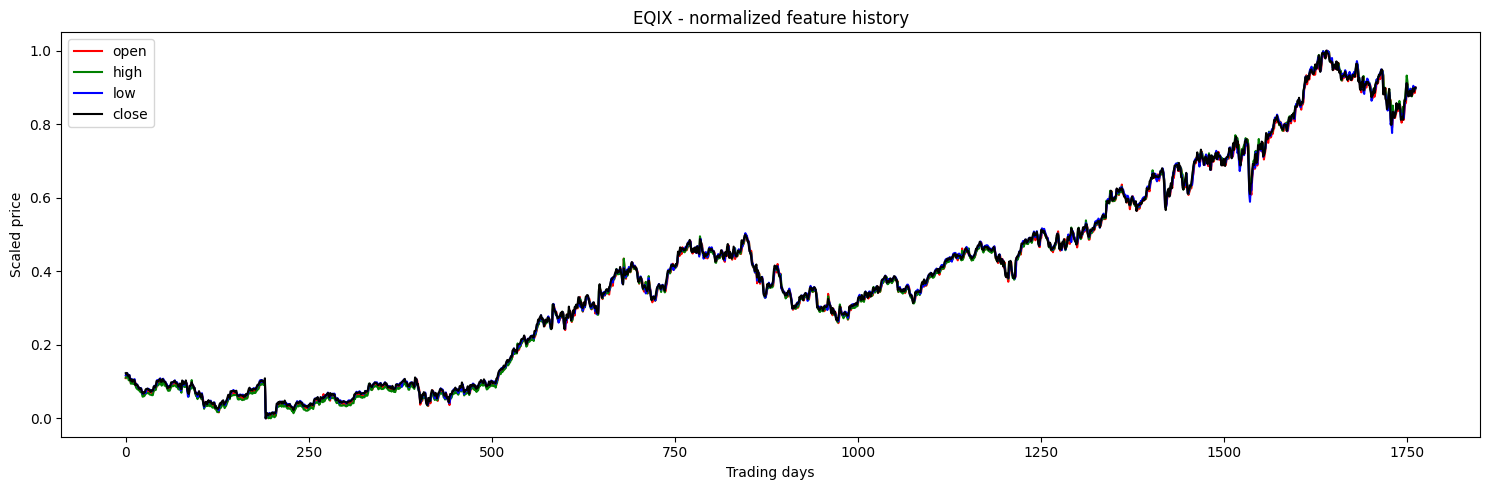

In [16]:
plt.figure(figsize=(15, 5))
for feature, color in zip(FEATURES, ["red", "green", "blue", "black"]):
    plt.plot(stock_scaled[feature].values, color=color, label=feature)

plt.title(f"{ticker} - normalized feature history")
plt.xlabel("Trading days")
plt.ylabel("Scaled price")
plt.legend(loc="best")
plt.tight_layout()
plt.show()


# 4. Build Model
Train a two-layer GRU network to predict the next day's normalized prices, using early stopping on the validation loss to avoid overfitting.


In [38]:


model = Sequential([
    # Input layer
    tf.keras.layers.Input(shape=(seq_len - 1, len(FEATURES))),

    # Hidden layer 1
    tf.keras.layers.GRU(200,
        activation="relu",
        return_sequences=True
    ),

    # Hidden layer 2
    tf.keras.layers.GRU(200,
        activation="relu"
    ),

    # Output layer
    tf.keras.layers.Dense(len(FEATURES), activation="linear")
])


model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="mse"
)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True
)


model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_6 (GRU)                     │ (None, 19, 200)        │       123,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_7 (GRU)                     │ (None, 200)            │       241,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           804 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 365,604 (1.39 MB)

 Trainable params: 365,604 (1.39 MB)

 Non-trainable params: 0 (0.00 B)

# 5 Train Model

In [39]:

# Model training

history = model.fit(
    x_train, y_train,
    epochs=100,
    batch_size=50,
    validation_data=(x_valid, y_valid),
    callbacks=[early_stop],
    verbose=1,
    shuffle=False
)


y_test_pred = model.predict(x_test)


Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - loss: 0.0036 - val_loss: 0.0031
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 0.0084 - val_loss: 0.0044
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 2.7518e-04 - val_loss: 7.2442e-04
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 1.9105e-04 - val_loss: 6.0386e-04
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 2.3983e-04 - val_loss: 6.7354e-04
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 1.8454e-04 - val_loss: 5.2533e-04
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 1.7541e-04 - val_loss: 5.3299e-04
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 1.9775e-04 - val_loss: 5.2056e-04
Epoch 9/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 1.6180e-04 - val_loss: 4.6444e-04
Epoch 10/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 1.5449e-04 - val_loss: 4.5779e-04
Epoch 11/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 1.6018e-04 - v

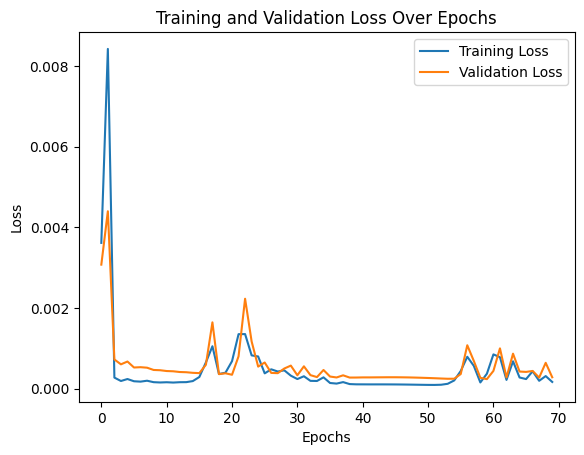

In [40]:
# Training diagnostics loss curve
plt.plot(history.history['loss']) # Plotting training loss
plt.plot(history.history['val_loss']) # Plotting validation loss
plt.title("Training and Validation Loss Over Epochs") # Adding title
plt.xlabel("Epochs") # Adding x-axis label
plt.ylabel("Loss") # Adding y-axis label
plt.legend(["Training Loss", "Validation Loss"])
plt.show() # Displaying the plot

# 6. Evaluate Predictions

Visualise forecasts against actual normalized prices and report mean squared error, mean absolute error, and directional accuracy (close minus open sign).


In [30]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Predict
y_pred = model.predict(x_test)

# Compute metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
MAE: 0.0107
RMSE: 0.0139


### 6.1 Plot Model [Example: Close Price]

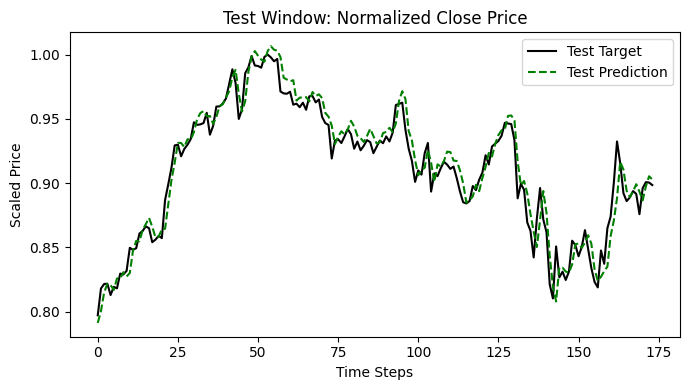

In [32]:
import matplotlib.pyplot as plt

# Target feature index (e.g., 'close' price)
target_feature_idx = 1  

# Define temporal limits of the test window
start = 0
end = len(y_test)

# Create figure
plt.figure(figsize=(7, 4))

# Black line: actual target values
plt.plot(range(start, end),
         y_test[:, target_feature_idx],
         label="Test Target",
         color="black")

# Green dashed line: predicted values
plt.plot(range(start, end),
         y_test_pred[:, target_feature_idx],
         label="Test Prediction",
         color="green",
         linestyle="--")

# Other graph customizations
plt.title("Test Window: Normalized Close Price")
plt.xlabel("Time Steps")
plt.ylabel("Scaled Price")
plt.legend(loc="best")
plt.tight_layout()
plt.show()


## Final Notes

## Next Steps

- Try alternative architectures such as deeper GRUs, LSTMs, or convolutional hybrids and compare validation metrics.
- Incorporate additional features (e.g., volume or technical indicators) after revisiting the preprocessing pipeline.
- Persist the fitted scaler and invert the predictions to interpret results in the original price units.
